** The notebook requires the python files we submitted. **

# Data Acquisition

We acquire data from TMDB, or The Movie DataBase, which is an open source version of IMDB, by using its API. Specifically, we do the following:
1. Get list of movie genres.
2. Obtain information of all movies in TMDB, including genres, overviews, poster paths, and etc.
3. Download posters for the movies in the preprocessed list of movies, and resize them into 224 X 224 (pixels).

In [1]:
import warnings
warnings.filterwarnings('ignore')

if False:
    
    import time
    import requests
    from collections import OrderedDict

    import tmdbsimple as tmdb # https://www.themoviedb.org/documentation/api
    tmdb.API_KEY = ''
    import imdb

    import pickle

    class IO:
        def __init__(self, file_name):
            self.file_name = file_name

        def to_pickle(self, obj):
            with open(self.file_name, 'wb') as output:
                pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)

        def read_pickle(self):
            with open(self.file_name, 'rb') as input_:
                obj = pickle.load(input_)
            return obj

    class CountRequest:
        def __init__(self, limit=40, stop=10):
            self.limit = limit
            self.stop = stop
            self.count = 0

        def add(self):
            self.count += 1
            if self.count % self.limit == 0:
                print('Sleep {} seconds...'.format(self.stop))
                time.sleep(self.stop)
            return self

    data_folder = '../data/'

    # Get list of genres
    tmdb_genres = tmdb.Genres().movie_list()
    cr.add()
    old_ids = []
    tmdb_genres_list = []
    for g in tmdb_genres['genres']:
        old_ids.append(g['id'])
        tmdb_genres_list.append(g['name'])
    old_id2new_id = {_i:i for i, _i in enumerate(old_ids)}
    IO(data_folder + 'tmdb_genres_list.pkl').to_pickle(tmdb_genres_list)

    # Get information of all movies in TMDB
    years = [y for y in range(1880, 2030)]
    tmdb_all = []

    for year in years:
        discover = tmdb.Discover().movie(year=year)
        cr.add()
        #print(year, discover['total_pages'], discover['total_results'])
        for page in range(1, min(discover['total_pages']+1, 1001)):
            tmdb_all.extend(tmdb.Discover().movie(year=year, page=page)['results'])
            cr.add()

    for m in tmdb_all:
        m['genre_ids'] = [old_id2new_id[i] for i in m['genre_ids']]

    IO(data_folder + 'tmdb_all.pkl').to_pickle(tmdb_all)

    # Download posters
    import requests
    poster_folder = '../data/posters/'

    def get_poster(moive_dict):
        url = 'http://image.tmdb.org/t/p/original' + moive_dict['poster_path']
        return requests.get(url).content

    tmdb_posters = []

    for i, movie in enumerate(data):
        img = get_poster(movie)
        with open(poster_folder + str(i) + '.jpg', 'wb') as f:
            f.write(img)
        tmdb_posters.append(movie)
        #print(i, movie['title'])
        time.sleep(0.1)

    IO(data_folder + 'tmdb_posters.pkl').to_pickle(tmdb_posters)

# Preprocessing

First we need to preprocess our data. For details see common.py. The following code assumes tmdb_posters.pkl in ../data folder and glove.6B.300d.txt in ../local/glove. Results are stored in /tmp, and after that they should be moved to ../local folder.

In [2]:
import pickle
import numpy as np
from common import Data, Split, Batches, encode_y, Vocab

if False:
    # load pickled data
    data_file = "../data/tmdb_posters.pkl"
    data = pickle.load(open(data_file, 'rb'))


    # get overviews from data
    OVERVIEWS = Data(np.array([d['overview'] for d in data]))
    # get title from data
    TITLES = Data(np.array([d['title'] for d in data]))

    OVERVIEWS.save("/tmp/overviews.pkl")
    TITLES.save("/tmp/titles.pkl")

    # get genres, encode as 'one'-hot vectors
    GENRES = Data(encode_y(np.array([d['genre_ids'] for d in data])))
    GENRES.save("/tmp/genres.pkl")

    # create train-val-test split
    train, val, test = OVERVIEWS.create_splits(0.8,0.1)
    train.save("/tmp/train.pkl")
    val.save("/tmp/val.pkl")
    test.save("/tmp/test.pkl")

    # create vocab, this is to support fine-tuning of embeddings (otherwise don't call add_sentences)
    # during this step, all punctuations are removed and all words are converted to lower cases.
    vocab = Vocab()
    vocab.initialize_glove("../local/glove/glove.6B.300d.txt")
    vocab.add_sentences(train.get_data(OVERVIEWS))
    vocab.add_sentences(train.get_data(TITLES))
    vocab.save("/tmp/vocab.pkl")

    # create embedding layer, for now we freeze the embedding layer. (default is freeze=True)
    embedding = vocab.create_pytorch_embeddings()
    torch.save(embedding, "/tmp/embedding.pth")

    # encode data as indices
    OVERVIEWS_ENCODED = Data(vocab.encode_sentences(OVERVIEWS.data))
    TITLES_ENCODED = Data(vocab.encode_sentences(TITLES.data))

    OVERVIEWS_ENCODED.save("/tmp/overviews_encoded.pkl")
    TITLES_ENCODED.save("/tmp/titles_encoded.pkl")

    del OVERVIEWS_ENCODED, TITLES_ENCODED, vocab, embedding, train, val, test, GENRES, TITLES, OVERVIEWS, data, data_file

In [3]:
# load saved preprocessed data
from common import load_data, load_split
GENRES = load_data("../local/genres.pkl")
train = load_split("../local/train.pkl")
val = load_split("../local/val.pkl")
test = load_split("../local/test.pkl")
OVERVIEWS = load_data("../local/overviews_encoded.pkl")
OVERVIEWS_ENCODED = OVERVIEWS

from sklearn.metrics import f1_score

def report(Y_true, Y_pred):
    print("acc:", np.mean([np.mean(Y_true[:,i] == Y_pred[:,i]) for i in range(19)]), "\tf1:",f1_score(Y_true, Y_pred, average="micro"))

# EDA

In [4]:
import sys
sys.path.append('../')
from modules import IO
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette("hls", 19)
%matplotlib inline

In [5]:
data_folder = '.././data/'
output_folder = '.././output/'
tmdb_genres_list = IO(data_folder + 'tmdb_genres_list.pkl').read_pickle()
movies = IO(data_folder + 'tmdb_posters.pkl').read_pickle()

In [6]:
tmdb_all = movies
print(len(tmdb_all))

tmdb_all_genres_count = np.zeros(len(tmdb_genres_list), dtype=int)
tmdb_overview_len = []

for m in tmdb_all:
    for i in m['genre_ids']:
        tmdb_all_genres_count[i] += 1
    tmdb_overview_len.append(len(m['overview'].split(' ')))
    
tmdb_overview_len = np.array(tmdb_overview_len)

30000


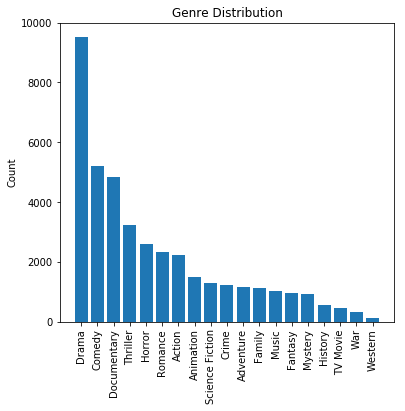

In [7]:
plt.figure(figsize=(6, 5.5))

plt.bar(range(len(tmdb_all_genres_count)), tmdb_all_genres_count[np.argsort(tmdb_all_genres_count)[::-1]]);
plt.xticks(range(len(tmdb_all_genres_count)), np.array(tmdb_genres_list)[np.argsort(tmdb_all_genres_count)[::-1]], \
           rotation=90);
plt.ylabel('Count');
plt.title('Genre Distribution');
#plt.savefig(output_folder + 'eda02.png', bbox_inches='tight');

The number of movie overviews with no less than 20 words: 20007
The number of movie overviews with no less than 50 words: 11830
The number of movie overviews with no less than 100 words: 3282


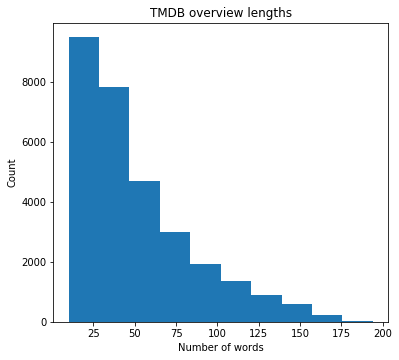

In [8]:
plt.figure(figsize=(6, 5.5))
plt.hist(tmdb_overview_len);
plt.xlabel('Number of words');
plt.ylabel('Count');
plt.title('TMDB overview lengths');
#plt.savefig(output_folder + 'eda03.png', bbox_inches='tight');

print('The number of movie overviews with no less than 20 words: {}'.format(np.sum(tmdb_overview_len >= 30)))
print('The number of movie overviews with no less than 50 words: {}'.format(np.sum(tmdb_overview_len >= 50)))
print('The number of movie overviews with no less than 100 words: {}'.format(np.sum(tmdb_overview_len >= 100)))

## Genre Biclustering

In [9]:
Genre_ID_to_name={}
for i in range(len(tmdb_genres_list)):
    genre_id=i
    genre_name=tmdb_genres_list[i]
    Genre_ID_to_name[genre_id]=genre_name

In [10]:
# This function just generates all possible pairs of movies
def list2pairs(l):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(l, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for i in l:
        pairs.append([i,i])
    return pairs

In [11]:
allPairs = []
for movie in movies:
    allPairs.extend(list2pairs(movie['genre_ids']))

In [12]:
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

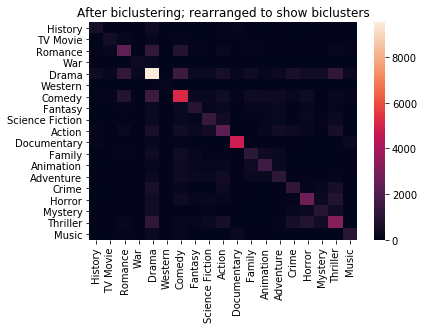

In [13]:
from sklearn.cluster import SpectralCoclustering
model = SpectralCoclustering(n_clusters=6)
model.fit(visGrid)

fit_data = visGrid[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

annot_lookup_sorted = []
for i in np.argsort(model.row_labels_):
    annot_lookup_sorted.append(Genre_ID_to_name[nr_ids[i]])
    
sns.heatmap(fit_data, xticklabels=annot_lookup_sorted, yticklabels=annot_lookup_sorted, annot=False)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

## Word Cloud

In [14]:
description_crime = np.array([m['overview'] for m in tmdb_all if 4 in m['genre_ids']])

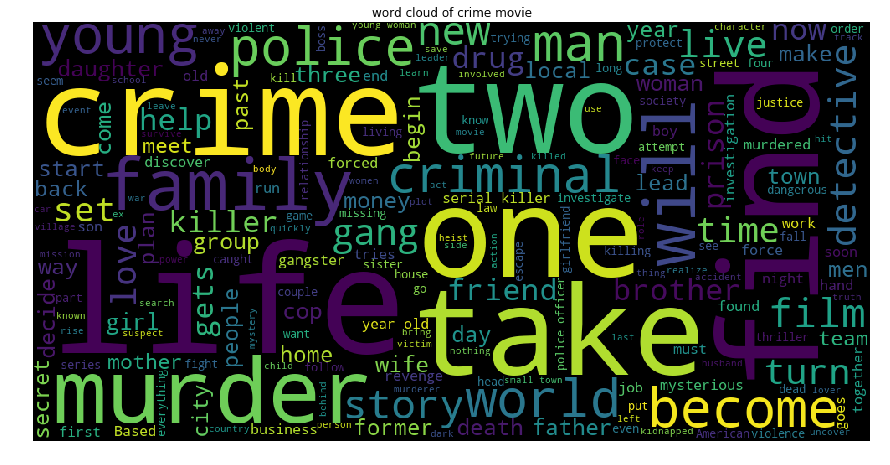

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(''.join(description_crime));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.title('word cloud of crime movie')
plt.axis('off');

In [16]:
description_romance = np.array([m['overview'] for m in tmdb_all if 13 in m['genre_ids']])

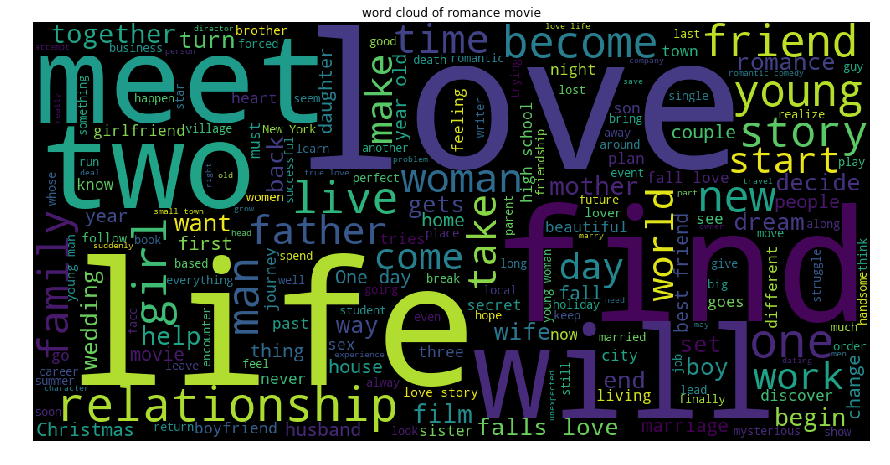

In [17]:
wordcloud = WordCloud(width = 1000, height = 500).generate(''.join(description_romance));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.title('word cloud of romance movie')
plt.axis('off');

## Other features

In [18]:
month = np.zeros([12, 19])

for i in range(19):
    for m in movies:
        if i in m['genre_ids']:
            month[int(m['release_date'].split('-')[1]) - 1, i] +=1

In [19]:
for t in range(12):
    month[t,:] /= month[t,:].sum()

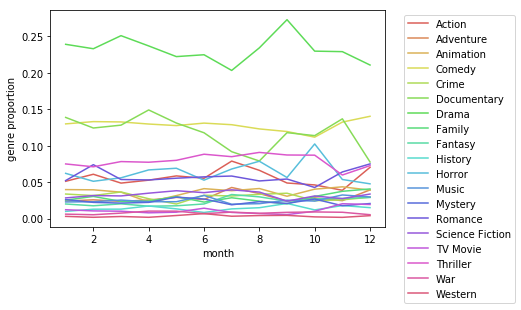

In [20]:
sns.set_palette("hls", 12)
for i in range(19):
    plt.plot(range(1,13), month[:,i], label = Genre_ID_to_name[i], color = color[i])

plt.xlabel('month')
plt.ylabel('genre proportion')
plt.legend(bbox_to_anchor=(1.04,1))

# SVM and NaiveBayes (Bag of Words)

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
    
X_train = train.get_data(OVERVIEWS)
X_val = val.get_data(OVERVIEWS)
X_test = test.get_data(OVERVIEWS)
Y_train = train.get_data(GENRES)
Y_val = val.get_data(GENRES)
Y_test = test.get_data(GENRES)

X_train = [" ".join([str(e) for e in x]) for x in X_train]
X_val = [" ".join([str(e) for e in x]) for x in X_val]
X_test = [" ".join([str(e) for e in x]) for x in X_test]

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)
X_test_cv = cv.transform(X_test)

In [22]:
svm = OneVsRestClassifier(LinearSVC())
svm.fit(X_train_cv, Y_train)
val_predict_svm = svm.predict(X_val_cv)
test_predict_svm = svm.predict(X_test_cv)
report(Y_val, val_predict_svm)
report(Y_test, test_predict_svm)

acc: 0.9324561403508771 	f1: 0.5014245014245015
acc: 0.9323333333333332 	f1: 0.49203213486105624


In [23]:
cv = CountVectorizer(max_df=0.95, min_df=0.005)

X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)
X_test_cv = cv.transform(X_test)

nb = OneVsRestClassifier(MultinomialNB())
nb.fit(X_train_cv, Y_train)
val_predict_nb = nb.predict(X_val_cv)
test_predict_nb = nb.predict(X_test_cv)
report(Y_val, val_predict_nb)
report(Y_test, test_predict_nb)

acc: 0.9071228070175439 	f1: 0.4241896889275614
acc: 0.9065438596491229 	f1: 0.42417035996108526


The performance of SVM is better than NB in our experiment.

# tf-idf

In [24]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_cv)
X_val_tfidf = tfidf.transform(X_val_cv)
X_test_tfidf = tfidf.transform(X_test_cv)

In [25]:
svm = OneVsRestClassifier(LinearSVC())
svm.fit(X_train_tfidf, Y_train)
val_predict_svm = svm.predict(X_val_tfidf)
test_predict_svm = svm.predict(X_test_tfidf)
report(Y_val, val_predict_svm)
report(Y_test, test_predict_svm)

acc: 0.9347719298245615 	f1: 0.3320158102766798
acc: 0.9348947368421053 	f1: 0.3219440891649918


In [26]:
cv = CountVectorizer(max_df=0.95, min_df=0.005)

X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)
X_test_cv = cv.transform(X_test)
X_train_tfidf = tfidf.fit_transform(X_train_cv)
X_val_tfidf = tfidf.transform(X_val_cv)
X_test_tfidf = tfidf.transform(X_test_cv)

nb = OneVsRestClassifier(MultinomialNB())
nb.fit(X_train_tfidf, Y_train)
val_predict_nb = nb.predict(X_val_tfidf)
test_predict_nb = nb.predict(X_test_tfidf)
report(Y_val, val_predict_nb)
report(Y_test, test_predict_nb)

acc: 0.9313333333333333 	f1: 0.1397802197802198
acc: 0.9323333333333332 	f1: 0.14345991561181437


tfidf doesn't improve the performance of our model.

# word2vec Embeddings

In [27]:
from gensim import models
model2 = models.KeyedVectors.load_word2vec_format('../local/GoogleNews-vectors-negative300.bin', binary=True)
OVERVIEWS_RAW = load_data("../local/overviews.pkl")

In [28]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

movie_mean_wordvec=np.zeros((len(OVERVIEWS_RAW),300))

# get mean word2vec embeddings
for i in range(len(OVERVIEWS_RAW)):
    text = OVERVIEWS_RAW.data[i]
    tokens = filter(lambda x:x not in en_stop, map(lambda x:x.lower(), tokenizer.tokenize(text)))
    tokens = filter(lambda x:x in model2.vocab, tokens)
    embs = map(lambda x:model2[x], tokens)
    
    embs = np.array(list(embs))
    embs = np.mean(embs, axis=0)
    
    movie_mean_wordvec[i,:] = embs

In [29]:
WORD2VEC = Data(movie_mean_wordvec)

X_train = train.get_data(WORD2VEC)
X_val = val.get_data(WORD2VEC)
X_test = test.get_data(WORD2VEC)
Y_train = train.get_data(GENRES)
Y_val = val.get_data(GENRES)
Y_test = test.get_data(GENRES)

In [30]:
svm = OneVsRestClassifier(LinearSVC())
svm.fit(X_train, Y_train)
val_predict_w2v = svm.predict(X_val)
test_predict_w2v = svm.predict(X_test)
report(Y_val, val_predict_w2v)
report(Y_test, test_predict_w2v)

acc: 0.9332280701754385 	f1: 0.28323917137476456
acc: 0.9342807017543858 	f1: 0.27933820700269335


# Deep Learning

## Text-Only Model

The model is composed of an encoder and a classifier. The encoder definition is:
```
class Encoder2(torch.nn.Module):
    def __init__(self, encoder, embedding, hidden_dim, input_channel, num_layers, bidirectional, dropout, cuda):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = embedding
        self.bidirectional = bidirectional
        self.cuda = cuda

        self.encoder = encoder(input_size=input_channel, hidden_size=hidden_dim, batch_first=True,
                                bidirectional=bidirectional, num_layers=num_layers, dropout=dropout)
        
        if cuda:
            self.embedding.cuda()
            self.encoder.cuda()

    def forward(self, pack:Pack):
        rev = pack.get_rev()
        data = pack.get_pack(self.embedding, torch_var=True)
        if self.cuda:
            rev.cuda()
        states_packed, _ = self.encoder(data) # (packed_sequence, hidden_state)
        states, _ = torch.nn.utils.rnn.pad_packed_sequence(states_packed)
        states = torch.cat([states[-1,:,:self.hidden_dim], states[0,:,self.hidden_dim:]], dim=1)
        return states[rev, :]
        
    def init_hidden(self):
        pass
```
The classifier definition is:
```
class BRClassifier(torch.nn.Module):
    def __init__(self, dims, num_class, encoding_size, cuda):
        super().__init__()
        
        self.classifiers = []
        for i in range(num_class):
            cls = MultiLayerFCReLUClassifier(dims, 1, encoding_size, cuda)
            self.add_module(str(i), cls)
            self.classifiers.append(cls)

    def forward(self, encodings):
        out = torch.stack([cls(encodings) for cls in self.classifiers])[:,:,0]
        return torch.transpose(out,0,1)
```

where MultiLayerFCReLUClassifier is defined as:
```
class MultiLayerFCReLUClassifier(torch.nn.Module):
    def __init__(self, dims, num_class, encoding_size, cuda):
        super().__init__()
        assert(len(dims)>0)
        self.fc1 = torch.nn.Linear(encoding_size, dims[0])
        self.relu1 = torch.nn.ReLU()
        if cuda:
            self.fc1.cuda()
            self.relu1.cuda()
        self.fcs = []
        self.relus = []
        prev_dim = dims[0]
        for dim in dims[1:]:
            fc = torch.nn.Linear(prev_dim, dim)
            relu = torch.nn.ReLU()
            if cuda:
                fc.cuda()
                relu.cuda()
            self.fcs.append(fc)
            self.relus.append(relu)
            prev_dim = dim
        
        self.out_fc = torch.nn.Linear(dims[-1], num_class)
        if cuda:
            self.out_fc.cuda()

    def forward(self, encodings):
        l_out = self.fc1(encodings)
        l_out = self.relu1(l_out)
        for i in range(len(self.fcs)):
            l_out = self.fcs[i](l_out)
            l_out = self.relus[i](l_out)
        out = self.out_fc(l_out)
        return out
```

The basic idea is encoder is a multi layer LSTM/GRU uni/bidirectional network and the classifier is a combinition of 19 binary classifiers. In our experiments, a 3-layer bidirectional LSTM performs best. It's easy to change to any combination of LSTM/GRU+uni/bidirectional+different hidden dim+different number of layers by changing the parameters of Encoder2 class.

In [31]:
import torch

embedding = torch.load('../local/embedding.pth').cuda()

from cls import BRClassifier
from torch_models import Encoder2
from model import TextOnlyModel
from train import train_epoches

classifier = BRClassifier(dims=[1024, 512], num_class=19, encoding_size=1024, cuda=True)
encoder = Encoder2(encoder=torch.nn.LSTM, embedding=embedding, input_channel=embedding.embedding_dim,
                  hidden_dim=512, num_layers=3, cuda=True, bidirectional=True, dropout=0)

# replace torch.nn.LSTM by torch.nn.GRU to use GRU
# change num_layers, hidden_dim, bidirectional to experiment with different configs
# dropout isn't very useful, we tried and it led to underfit.

model = TextOnlyModel(encoder, classifier, OVERVIEWS_ENCODED, GENRES)
loss = torch.nn.BCEWithLogitsLoss().cuda()
adam = torch.optim.Adam(filter(lambda p:p.requires_grad, model.parameters()))

optimizer = adam
scheduler = None

loss_hist = []
save_per_epoch = 10
n_epochs = 0 # change this to train

for i in range(int(n_epochs/save_per_epoch)): 
    epoch_losses = train_epoches(n_epochs=save_per_epoch, model=model, train=train, loss=loss, val=val,
                  batch_size=32, optimizer=optimizer, scheduler=scheduler)
    loss_hist.append(epoch_losses)
    bn = (i+1)*save_per_epoch
    torch.save(model.encoder, "/tmp/encoder_{}_{}.pth".format(bn, str(epoch_losses[1][1][-1])[:4]))
    torch.save(model.classifier, "/tmp/cls_{}_{}.pth".format(bn, str(epoch_losses[1][1][-1])[:4]))

In [32]:
from utils import evaluate, inference
encoder = torch.load("./saved/overview-lstm2/encoder_70_0.53.pth")
encoder.encoder.cuda()
classifier = torch.load("./saved/overview-lstm2/cls_70_0.53.pth").cuda()
model = TextOnlyModel(encoder, classifier, OVERVIEWS_ENCODED, GENRES)
Yp_val, Yt_val = inference(split=val, model=model, batch_size=128)
Yp_test, Yt_test = inference(split=test, model=model, batch_size=128)

In [33]:
report(Yt_val, Yp_val)
report(Yt_test, Yp_test)
del model, encoder, classifier, optimizer, scheduler, adam, loss

acc: 0.9354561403508772 	f1: 0.5327067191667725
acc: 0.9342456140350878 	f1: 0.5147591921284308


Our RNN performs better than all previous models. But what about we do something more interesting? Like using the posters?

## Poster-Only Model

We need to preprocess the posters. We assume posters are in ../local/posters. We need to copy posters.npy from tmp to ../local after preprocessing. We essentially convert images into matrices, and apply the transformation required by the torchvision models.

In [34]:
import cv2
import os

from torchvision import transforms

# For efficiency we load all images into RAM and do the preprocessing. This requires A LOT OF RAM space.
# Instead the images could be processes individually and combined afterwards.
if False:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    toTensor = transforms.ToTensor()
    preprocess = transforms.Compose([toTensor, normalize])

    images_list = []

    image_folder = "../local/posters/"
    for i in range(30000):
        f = os.path.join(image_folder, "{}.jpg".format(i))
        I = cv2.imread(f)
        assert(I is not None)
        I = preprocess(I)
        images_list.append(I.numpy())

    images = np.stack(images_list)

    POSTERS = Data(images)
    assert(len(POSTERS)==30000)
    POSTERS.save("/tmp/posters.npy")

The structure of poster-only model is very similar to TextOnlyModel, except for that now the encoder is replaced by CNN. We tried both VGG16 and RESNET152 as our encoder, and found RES152 is better.

In [35]:
from torchvision.models import resnet152, vgg16
from model import PosterOnlyModel

POSTERS = load_data("../local/posters.npy")

if True:
    MODEL = resnet152(pretrained=True)
    # Freeze base layers
    for child in list(MODEL.children())[:-3]:
        for param in child.parameters():
            param.requires_grad = False
    MODEL = torch.nn.Sequential(*list(MODEL.children())[:-1]).cuda()

    # Conv4, turn off grad in first 2 blocks
    for child in list(list(MODEL.children())[-3].children())[:2]:
        for param in child.parameters():
            param.requires_grad = False
else:
    # in order to use VGG16, just use the following code instead of the code above
    MODEL = vgg16(pretrained=True)
    # Freeze base layers (except for the last three conv layers)
    for child in list(MODEL.features.children())[:-7]:
        for param in child.parameters():
            param.requires_grad = False
    MODEL = MODEL.features.cuda()
    
classifier = BRClassifier(dims=[1024, 512], num_class=19, encoding_size=2048, cuda=True)

model = PosterOnlyModel(MODEL, classifier, POSTERS, GENRES)

adam = torch.optim.Adam(filter(lambda p:p.requires_grad, model.parameters()))

optimizer = adam
scheduler = None

loss = torch.nn.BCEWithLogitsLoss().cuda()

n_epochs = 0 # change this to train
save_per_epoch = 10
for i in range(int(n_epochs/save_per_epoch)): 
    epoch_losses = train_epoches(n_epochs=save_per_epoch, model=model, train=train, loss=loss, val=val,
                  batch_size=16, optimizer=optimizer, scheduler=scheduler)
    loss_hist.append(epoch_losses)
    bn = (i+1)*save_per_epoch
    torch.save(model.encoder, "/tmp/cnn_encoder_{}_{}.pth".format(bn, str(epoch_losses[1][1][-1])[:4]))
    torch.save(model.classifier, "/tmp/cnn_cls_{}_{}.pth".format(bn, str(epoch_losses[1][1][-1])[:4]))

In [36]:
# our model was trained using pytorch 3. Pytorch 4 was released a week before the due date 
#  and this function is necessary to run saved pytorch 3 CNN model on pytorch 4. 
def migrate_pt3_pt4(module):
    if  isinstance(module, torch.nn.modules.batchnorm.BatchNorm1d) or \
        isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d) or \
        isinstance(module, torch.nn.modules.batchnorm.BatchNorm3d):
        module.track_running_stats = True
    for c in module.children():
        migrate_pt3_pt4(c)

In [37]:
encoder = torch.load("./saved/poster-res2/encoder_80_0.45.pth")
migrate_pt3_pt4(encoder)
encoder.cuda()
classifier = torch.load("./saved/poster-res2/cls_80_0.45.pth").cuda()
model = PosterOnlyModel(encoder, classifier, POSTERS, GENRES)
Yp_val, Yt_val = inference(split=val, model=model, batch_size=32)
Yp_test, Yt_test = inference(split=test, model=model, batch_size=32)

In [38]:
report(Yt_val, Yp_val)
report(Yt_test, Yp_test)
del model, MODEL, classifier, optimizer, scheduler, adam, loss

acc: 0.9317894736842104 	f1: 0.45208568207440814
acc: 0.9302280701754384 	f1: 0.4304740083058857


The poster-only model is worse than text-only model and several traditional models. But it's not surprising because inferring genre from poster is harder (even for humans) than from overview text. But what if we combine the poster model with text model? 

## Combined Model

The model is simple, the CNN and RNN operates independently, and the encodings from both networks are then stacked and fed to a classifier.

We wanted to train the combined model, but the GPU RAM is too small! So instead we fixed RNN and CNN, and only train the classifier.

The combined encoder is simple as 

```
class TextPosterCombinedEncoder(torch.nn.Module):
    def __init__(self, text_encoder, poster_encoder):
        super().__init__()
        self.text_encoder = text_encoder
        self.poster_encoder = poster_encoder
        
    def forward(self, text_pack, posters):
        poster_encodings = self.poster_encoder(posters).view(len(posters),-1)
        text_encodings = self.text_encoder(text_pack)
        return poster_encodings, text_encodings
```

In [39]:
from torch_models import TextPosterCombinedEncoder
from model import TextPosterCombinedModel

text_encoder = torch.load("./saved/overview-lstm2/encoder_70_0.53.pth")
posters_encoder = torch.load("./saved/poster-res2/encoder_80_0.45.pth")

encoder = TextPosterCombinedEncoder(text_encoder, posters_encoder).cuda()

for param in encoder.parameters():
    param.requires_grad = False
    
classifier = BRClassifier(dims=[1024, 512], num_class=19, encoding_size=2048+1024, cuda=True)

optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, classifier.parameters()))
loss = torch.nn.BCEWithLogitsLoss().cuda()

scheduler=None

model = TextPosterCombinedModel(encoder, classifier, OVERVIEWS_ENCODED, POSTERS, GENRES)

n_epochs = 0 # change this to train
save_per_epoch = 4
for i in range(int(n_epochs/save_per_epoch)): 
    epoch_losses = train_epoches(n_epochs=save_per_epoch, model=model, train=train, loss=loss, val=val,
                  batch_size=32, optimizer=optimizer, scheduler=scheduler)
    bn = (i+1)*save_per_epoch
    torch.save(model.classifier, "/tmp/cbn_cls_{}_{}.pth".format(bn, str(epoch_losses[1][1][-1])[:4]))

In [40]:
classifier = torch.load("./saved/cbn/cls_4_0.54.pth").cuda()
migrate_pt3_pt4(encoder)
model = TextPosterCombinedModel(encoder, classifier, OVERVIEWS_ENCODED, POSTERS, GENRES)

Yp_val, Yt_val = inference(split=val, model=model, batch_size=32)
Yp_test, Yt_test = inference(split=test, model=model, batch_size=32)

In [41]:
# get the output unit values (probas) for interpretation
Yp_test_proba, Yt_test_proba = inference(split=test, model=model, batch_size=32, proba=True)
np.save("Y_pred_test.npy", Yp_test_proba)
np.save("Y_true_test.npy", Yt_test_proba)

In [42]:
report(Yt_val, Yp_val)
report(Yt_test, Yp_test)
del model, encoder, classifier, optimizer, scheduler, loss

acc: 0.945157894736842 	f1: 0.5420451215939057
acc: 0.9437543859649123 	f1: 0.5186186186186187


The result is slightly better than TextOnlyModel thus having the best performance. The result could be better if we don't fix some layers of the RNN and CNN, but it requires more GPU RAM. Maybe training on a more powerful GPU or multiple GPUs is a possible future direction.

# Interpretation

In [43]:
import numpy as np
import torch

Y_pred = np.load("./Y_pred_test.npy")
Y_true = np.load("./Y_true_test.npy")
Y_pred_sigmoid = torch.nn.functional.sigmoid(torch.from_numpy(Y_pred)).numpy()

genres = np.load("../data/tmdb_genres_list.pkl")

results = {}

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
import pandas as pd

def number(n):
    return "%.2f%%"%(n*100)

def sprint(*args, sep=" ", end="\n"):
    return sep.join([str(s) for s in args])+end

for i in range(len(genres)):
    pred = Y_pred[:, i]>0
    label = Y_true[:, i]
    pred_sigmoid = Y_pred_sigmoid[:, i]
    result = dict([
        ("F1", number(f1_score(label, pred))),
        ("Precision", number(precision_score(label, pred))),
        ("Recall", number(recall_score(label, pred))),
        ("AUC", number(roc_auc_score(label, pred_sigmoid))),
        ("Accuracy", number(accuracy_score(label, pred))),
    ])
    results[genres[i]] = result

df = pd.DataFrame(results, index=["F1", "Precision", "Recall", "Accuracy", "AUC"]).T
df

,F1,Precision,Recall,Accuracy,AUC
Action,50.31%,61.54%,42.55%,94.73%,86.99%
Adventure,36.64%,66.67%,25.26%,97.23%,87.94%
Animation,45.61%,71.23%,33.55%,95.87%,89.01%
Comedy,53.68%,61.69%,47.51%,85.73%,83.52%
Crime,33.92%,76.32%,21.80%,96.23%,83.47%
Documentary,56.14%,64.36%,49.79%,87.87%,85.37%
Drama,60.30%,60.21%,60.40%,74.77%,79.85%
Family,36.81%,65.22%,25.64%,96.57%,80.32%
Fantasy,32.73%,81.82%,20.45%,97.53%,85.08%
History,44.78%,100.00%,28.85%,98.77%,86.62%
